**Name:** Luk Wing San (20193803), Gao Shenlai(20256746), Cheung Tin Yan (20197342)

**Math 4432: Project 3 Report Summary**

**Problem chosen:** Nexperia Predictive Maintenance Full 2

**Question proposed:** Which features may be more important than others for predicting failure? Which model may perform better?

**Goal:** Build a good prediction model with high area-under-curve (it is evaluated by Kaggle)

**Contributions:** Luk Wing San 1/3, Gao Shenlai 1/3, Timothy Cheung 1/3

This report takes reference from two of our reports, which are Nexperia Predictive Maintenance Contest (Mini) and Nexperia Predictive Maintenance Full 1. The only difference is the change of training and testing dataset, in which this time we use 16 oberservation windows and 2 prediction windows. Moreover, we only focus on logistic regression, random forest and SVM here, unlike that we try several neural network methods in the mini contest report. For the training feature, after different trials and combinations, we find out the counts of error 136222210 and 136224578, as well as mean of 136224578 can give the highest accuracy score on Kaggle in Nexperia Predictive Maintenance Full 2. Other parts in this report is basically the same as the two other reports for Mini Contest and Nexperia Predictive Maintenance Full 1. We rank 3rd in Nexperia Predictive Maintenance Full 2 with score 0.55344 on Kaggle. (account name on experia Predictive Maintenance Full 2 contest on Kaggle: Luk Wing San). Our report on Nexperia Predictive Maintenance Contest (Mini) and Nexperia Predictive Maintenance Full 1 can use as detailed reference for this report. Please look at these two reports for reference.

### Import Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import datetime

from matplotlib.colors import ListedColormap
from scipy import stats
from sklearn.cross_validation import KFold
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc

stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

%matplotlib inline

/Users/lukwingsan/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/lukwingsan/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/lukwingsan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/lukwingsan/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_sel

### Simple Helpful Functions and a Little Preprocessing for Neat Data

In [3]:
def getData(path, mode='train'):
    df = pd.read_csv(path, dtype = str, header=[0,1], skiprows = [2])
#     print(df.columns.values)
    df.columns = ['_'+'_'.join(tup).rstrip('_')+'_' for tup in df.columns.values]
    df = df.rename(columns = {'_Unnamed: 0_level_0_Unnamed: 0_level_1_':'Machine', '_Unnamed: 1_level_0_Unnamed: 1_level_1_':'Date', '_Label_Unnamed: 83_level_1_': 'Label'})
    if mode == 'train':
        # some rows in training data doesn't have the label so we drop them
        df = df.dropna(subset=['Label'])
        label = [1 if l == 'True' else 0 for l in df['Label']]
        df['Label'] = label
    df = df.fillna(0)
    return df
def get_roc_and_area(predictions_test, outcome_test):
    fpr, tpr, thresholds = roc_curve(predictions_test, outcome_test)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
def writecsv (ypred, data, file_name):
    date=data['_Unnamed: 1_Unnamed: 2_level_1_'].copy()
    date=[datetime.datetime.strptime(d, "%Y-%m-%d" ).date().strftime("%d/%m/%Y") for d in date]
    submission = pd.DataFrame({
        "id": data["_Unnamed: 0_Unnamed: 1_level_1_"]+'-'+date,
        "Label": ypred
    })
    submission.to_csv(file_name, sep=',', index=False)
def measureResult (ypred, ytest, Logging=True):
    mse = np.mean((ytest - ypred)**2)
    accuracy = np.mean(ytest == ypred)
    Survived_mean=np.mean(ytest)
    uss=np.mean((ytest - ypred)**2)
    dss=np.mean((ytest - Survived_mean)**2)
    r2 = 1-uss/dss
    if Logging:
        print('mse ', mse)
        print('accuracy', accuracy)
        print('R2', r2)
    return mse, accuracy, r2

### a Little Exploration

In [119]:
train = getData('data/full1_upload/training_data/Training freq 1D, OW 16, PW 1.csv')
train.head()

,Machine,Date,_1_count_,_1_vMean_,_1_vStd_,_136088194_count_,_136088194_vMean_,_136088194_vStd_,_136088202_count_,_136088202_vMean_,...,_136676698_count_,_136676698_vMean_,_136676698_vStd_,_136676714_count_,_136676714_vMean_,_136676714_vStd_,_136676754_count_,_136676754_vMean_,_136676754_vStd_,Label
0,M040_A1,2015-06-14,23.0,54841.31988631818,121741.39883332458,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M040_A1,2015-06-15,12.0,51813.133727,67261.98452681443,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M040_A1,2015-06-16,12.0,51813.133727,67261.98452681443,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M040_A1,2015-06-17,13.0,81078.73184941667,116483.42192648024,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M040_A1,2015-06-18,14.0,78175.95402199999,112364.49123839459,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
def explore(data):
    # total count for each of the count feature for different label
    countDict1 = {}
    countDict0 = {}
    for col in data.columns:
        if col.find('count') != -1:
            m = data[data['Label']==1][col]
            mFloat = [float(v) for v in m.values]
            countDict1[col] = np.sum(mFloat)
            m = data[data['Label']==0][col]
            mFloat = [float(v) for v in m.values]
            countDict0[col] = np.sum(mFloat)
    for key in countDict1:
        # the count feature, count for label 0, count for label 1, ratio
        print(key, countDict1[key], countDict0[key], countDict1[key]/countDict0[key], end='\n')
        
    appeared = {}
    for col in data.columns:
        if col.find('count') != -1:
            m = data[data['Label']==1][col]
            mFloat = [float(v) for v in m.values]
            k = []
            for v in mFloat:
                k.append(v > 0)

            m = data[data['Label']==0][col]
            mFloat = [float(v) for v in m.values]
            k2 = []
            for v in mFloat:
                k2.append(v > 0)
            # for each count feature, how many of it is larger than 0 for different labels
            appeared[col] = [np.sum(k), np.sum(k2), np.sum(k)/np.sum(k2)]
    for key in appeared:
        print(key, appeared[key])

    # total count for each of the count feature for different label for each machine
    machines = np.unique(data['Machine'])
    for machine in machines:
        machineRecords = data[data['Machine']==machine]

        days = machineRecords['Machine'].count()
        
        countDict1 = {}
        countDict0 = {}
        for col in machineRecords.columns:
            if col.find('count') != -1:
                m = machineRecords[machineRecords['Label']==1][col]
                mFloat = [float(v) for v in m.values]
                countDict1[col] = np.sum(mFloat)
                m = machineRecords[machineRecords['Label']==0][col]
                mFloat = [float(v) for v in m.values]
                countDict0[col] = np.sum(mFloat)

        print(machine)
        print(days, ' days')
        for key in countDict1:
            print(key, countDict1[key], countDict0[key], countDict1[key]/countDict0[key], end='\n')
explore(train)

_1_count_ 6849.0 57452.0 0.1192125600501288
_136088194_count_ 2724.0 28626.0 0.0951582477468036
_136088202_count_ 957.0 8070.0 0.11858736059479554
_136088394_count_ 950.0 9199.0 0.10327209479291227
_136088802_count_ 2204.0 13382.0 0.16469884920041847
_136089546_count_ 1691.0 13478.0 0.12546371865261907
_136110468_count_ 1811379.0 25319225.0 0.07154164473833619
_136216674_count_ 755.0 6555.0 0.11517925247902365
_136222202_count_ 20445.0 218316.0 0.09364865607651295
_136222210_count_ 9917.0 105825.0 0.09371131585164186
_136222234_count_ 519.0 4948.0 0.10489086499595797
_136222250_count_ 2097.0 19237.0 0.10900868118729531
_136222882_count_ 1453.0 14733.0 0.09862214077241567
_136223186_count_ 2383.0 23226.0 0.10260053388443985
_136224578_count_ 95689.0 851222.0 0.11241368291702987
_136224586_count_ 65777.0 683905.0 0.09617856281208648
_136224978_count_ 2162.0 23149.0 0.0933949630653592
_136225010_count_ 227881.0 2792388.0 0.08160792841109474
_136675426_count_ 818.0 15800.0 0.05177215189873

/Users/lukwingsan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


986  days
_1_count_ 575.0 6386.0 0.09004071406201065
_136088194_count_ 109.0 2091.0 0.05212816834050694
_136088202_count_ 114.0 698.0 0.16332378223495703
_136088394_count_ 0.0 0.0 nan
_136088802_count_ 84.0 752.0 0.11170212765957446
_136089546_count_ 119.0 1349.0 0.08821349147516679
_136110468_count_ 195243.0 1812665.0 0.10771047049509976
_136216674_count_ 0.0 28.0 0.0
_136222202_count_ 1713.0 18740.0 0.09140875133404483
_136222210_count_ 1543.0 12411.0 0.12432519539118524
_136222234_count_ 16.0 416.0 0.038461538461538464
_136222250_count_ 114.0 1445.0 0.07889273356401384
_136222882_count_ 211.0 2441.0 0.08643998361327325
_136223186_count_ 96.0 1634.0 0.0587515299877601
_136224578_count_ 8423.0 80255.0 0.10495296243224721
_136224586_count_ 9155.0 77154.0 0.11865878632345699
_136224978_count_ 32.0 1200.0 0.02666666666666667
_136225010_count_ 11635.0 114533.0 0.10158644233539678
_136675426_count_ 69.0 843.0 0.08185053380782918
_136675626_count_ 0.0 0.0 nan
_136676578_count_ 33.0 408.0 0.

In [6]:
# build a random forest model
def RandomForestModel (train_X, train_y, num_estimator):
    randomforest = RandomForestClassifier(n_estimators=num_estimator)
    randomforest.fit(train_X, train_y)
    return randomforest
def processData (data):
    newData = pd.DataFrame()
    for col in data.columns:
        if col not in ['Label','Machine','Date']:
            newData[col+'0_']=data[col]
            newData[col+'1_']=data[col].copy().shift(1)
            newData[col+'2_']=data[col].copy().shift(2)
    # todo: values for different machine should not be in the same line
    newData = newData.fillna(0)

    return newData

699 9000 0.07766666666666666
240 2526 0.09501187648456057
0.036333333333333336 0.9636666666666667 0.4927959969661141


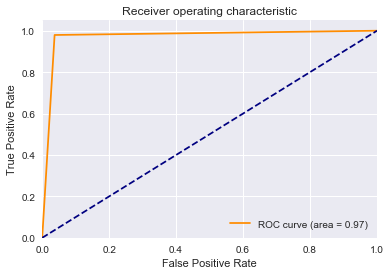

0.12707838479809977 0.8729216152019003 -0.47791994750661027


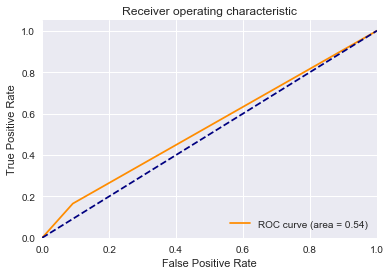

In [7]:
train = getData('data/upload_full2/training_data/Training freq 1D, OW 16, PW 2.csv')
verification = getData('data/upload_full2/test_feature/Verification freq 1D, OW 16, PW 2_feature.csv', 'test')
ptrain = processData(train)
pverification = processData(verification)
                
dataX = ptrain.copy()
datay = train['Label'].copy()

train_X = (dataX[0:9000])
train_y = datay[0:9000]
test_X = (dataX[9001:len(dataX)])
test_y = datay[9001:len(datay)]

print(np.sum(train_y), len(train_y), np.sum(train_y)/len(train_y))
print(np.sum(test_y), len(test_y), np.sum(test_y)/len(test_y))

random_forest = RandomForestModel(train_X, train_y, 2)
y_pred = random_forest.predict(train_X)
mse, acc, r2 = measureResult(y_pred, train_y, False)
print(mse, acc, r2)
get_roc_and_area(y_pred, train_y)

y_pred = random_forest.predict(test_X)
mse, acc, r2 = measureResult(y_pred, test_y, False)
print(mse, acc, r2)
get_roc_and_area(y_pred, test_y)

243 243


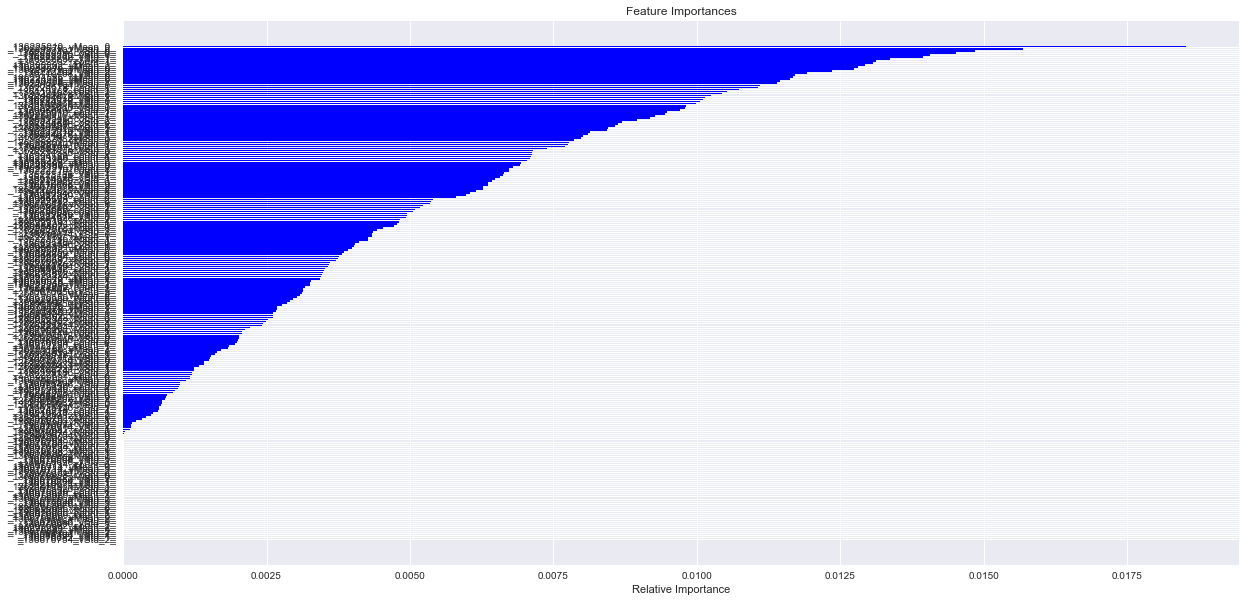

Index(['_136088194_vStd_0_', '_136224578_vMean_1_', '_136110468_vMean_2_',
       '_136224578_vMean_0_', '_136224586_vMean_2_', '_1_vStd_0_',
       '_136110468_vStd_2_', '_136222202_vStd_2_', '_136224978_vMean_0_',
       '_136089546_vMean_0_', '_136222202_vMean_2_', '_1_vStd_1_',
       '_136222202_count_1_', '_136222250_vStd_1_', '_136222202_vStd_1_',
       '_136222210_vStd_0_', '_136222210_count_0_', '_136222202_vStd_0_',
       '_136224578_vMean_2_', '_136225010_vMean_0_'],
      dtype='object')


In [8]:
features_names = train_X.columns
importances = random_forest.feature_importances_
print(len(importances), len(features_names))
indices = np.argsort(importances)
plt.figure(figsize=(20,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features_names[indices])
plt.xlabel('Relative Importance')
plt.show()
print(features_names[indices[len(indices)-20:len(indices)]])

### Logitstic Regression with Label Weights

In [11]:
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)

    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.4f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.4f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.4f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.4f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.4f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    plt.tight_layout()
    plt.show()
    return (tp / (tp+fn+0.))
def get_roc_and_area(predictions_test, outcome_test):
    fpr, tpr, thresholds = roc_curve(predictions_test, outcome_test)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    




In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight


def train_and_calibrate_cv(model, X_tr, y_tr,cv):
    from sklearn.model_selection import StratifiedKFold
    y_pred_xval = np.zeros(len(y_tr))
    skf = StratifiedKFold(cv,shuffle=True)
    total=0;
    i = 0;
    #Maxmodel;
    MaxTruePositive=0;
    for train, test in skf.split(X_tr,y_tr):
        average=0
        i = i+1
        print("training fold {} of {}".format(i, cv))
        X_train_xval = np.array(X_tr)[train,:]
        X_test_xval = np.array(X_tr)[test,:]
        y_train_xval = np.array(y_tr)[train]
        y_test_xval=np.array(y_tr)[test]
        # We could also copy the model first and then fit it
       # model_copy = model
       # class_Weight = class_weight.compute_class_weight('balanced',np.unique(y_train_xval),y_train_xval)
        model.fit(X_train_xval,y_train_xval)
        #confusion_matrix(y_true, y_pred)
        C = confusion_matrix(y_test_xval, model.predict(X_test_xval))
        #np.set_printoptions(precision=2)
        #plt.figure()
        #plot_confusion_matrix(C, classes= y_tr,title='Confusion matrix, without normalization')
        #plt.show()
        average=show_confusion_matrix(C, ['No Failure', 'Failure'])
        get_roc_and_area(model.predict(X_test_xval), y_test_xval)
        if (average>MaxTruePositive):
            MaxTruePositive=average
            Maxmodel=model
        total = average + total
        #print(test)
        #print(train)
        #y_pred_xval[test]=model.predict_proba(X_test_xval)[:,1]
    print("average true positive rate:" ,total/cv)
    print("Maximum true positive rate:",MaxTruePositive)
    print("training full model")
    #model_copy = model
    #model.fit(X_tr,y_tr)
    #print("calibrating function")
    #calib_func = prob_calibration_function(y_tr, y_pred_xval)
    #test1
    #C = confusion_matrix(y_test_xval, Maxmodel.predict(X_test_xval))
    #show_confusion_matrix(C, ['Not Trend', 'Trend'])
    #get_roc_and_area(Maxmodel.predict(X_test_xval), y_test_xval)
    #print(X_test_xval)
    #print(model.predict(X_test_xval))
    #print(y_test_xval)
    return Maxmodel,test, train
    
#logisticRegr = LogisticRegression() 
#model, test, train = train_and_calibrate_cv(logisticRegr,df[training_features],df[target],10)
#for i in test:
#    model.predict(df.loc(i))
#print(model.predict(X_test_xval))
#print(y_test_xval)
#df['y_hats'] = y_hats.reset_index()[target]

In [9]:
def processNew_Data (data):
    newData = pd.DataFrame()
    newData['Machine']=data['Machine']
    newData['Date']=data['Date']
    for col in data.columns:
        if col not in ['Label','Machine','Date']:
            newData[col+'0_']=data[col]
            newData[col+'1_']=data[col].copy().shift(1)
            newData[col+'2_']=data[col].copy().shift(2)
            
    # todo: values for different machine should not be in the same line
        
    newData = newData.fillna(0)
    arr=np.sum(newData.values[:,2:].astype(float), axis=1)
    newData['totalCount'] = arr
    newData['Label']=data['Label']
    
    return newData
newtrain = processNew_Data(train)
newtrain.head()


,Machine,Date,_1_count_0_,_1_count_1_,_1_count_2_,_1_vMean_0_,_1_vMean_1_,_1_vMean_2_,_1_vStd_0_,_1_vStd_1_,...,_136676754_count_1_,_136676754_count_2_,_136676754_vMean_0_,_136676754_vMean_1_,_136676754_vMean_2_,_136676754_vStd_0_,_136676754_vStd_1_,_136676754_vStd_2_,totalCount,Label
0,M040_A1,2015-06-14,23.0,0,0,54841.31988631818,0,0,121741.39883332458,0,...,0,0,0,0,0,0,0,0,1.624724e+06,0
1,M040_A1,2015-06-15,12.0,23.0,0,51813.133727,54841.31988631818,0,67261.98452681443,121741.39883332458,...,0,0,0,0,0,0,0,0,3.035418e+06,0
2,M040_A1,2015-06-16,12.0,12.0,23.0,51813.133727,51813.133727,54841.31988631818,67261.98452681443,67261.98452681443,...,0,0,0,0,0,0,0,0,4.495723e+06,0
3,M040_A1,2015-06-17,13.0,12.0,12.0,81078.73184941667,51813.133727,51813.133727,116483.42192648024,67261.98452681443,...,0,0,0,0,0,0,0,0,4.412408e+06,0
4,M040_A1,2015-06-18,14.0,13.0,12.0,78175.95402199999,81078.73184941667,51813.133727,112364.49123839459,116483.42192648024,...,0,0,0,0,0,0,0,0,4.539439e+06,0


In [27]:
newtrain['Label'].describe()



count    11683.000000
mean         0.074467
std          0.262541
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Label, dtype: float64

In [28]:
newtrain.groupby('Label').size()

Label
0    10813
1      870
dtype: int64

In [29]:
list(newtrain)

['Machine',
 'Date',
 '_1_count_0_',
 '_1_count_1_',
 '_1_count_2_',
 '_1_vMean_0_',
 '_1_vMean_1_',
 '_1_vMean_2_',
 '_1_vStd_0_',
 '_1_vStd_1_',
 '_1_vStd_2_',
 '_136088194_count_0_',
 '_136088194_count_1_',
 '_136088194_count_2_',
 '_136088194_vMean_0_',
 '_136088194_vMean_1_',
 '_136088194_vMean_2_',
 '_136088194_vStd_0_',
 '_136088194_vStd_1_',
 '_136088194_vStd_2_',
 '_136088202_count_0_',
 '_136088202_count_1_',
 '_136088202_count_2_',
 '_136088202_vMean_0_',
 '_136088202_vMean_1_',
 '_136088202_vMean_2_',
 '_136088202_vStd_0_',
 '_136088202_vStd_1_',
 '_136088202_vStd_2_',
 '_136088394_count_0_',
 '_136088394_count_1_',
 '_136088394_count_2_',
 '_136088394_vMean_0_',
 '_136088394_vMean_1_',
 '_136088394_vMean_2_',
 '_136088394_vStd_0_',
 '_136088394_vStd_1_',
 '_136088394_vStd_2_',
 '_136088802_count_0_',
 '_136088802_count_1_',
 '_136088802_count_2_',
 '_136088802_vMean_0_',
 '_136088802_vMean_1_',
 '_136088802_vMean_2_',
 '_136088802_vStd_0_',
 '_136088802_vStd_1_',
 '_136088

training fold 1 of 10


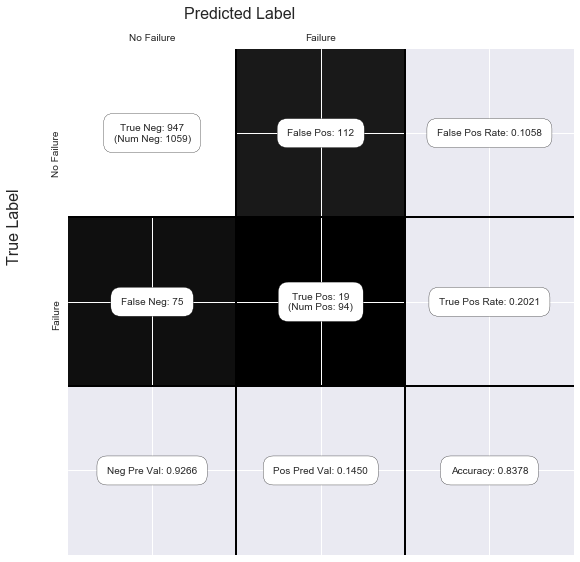

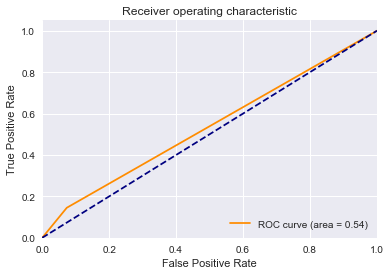

training fold 2 of 10


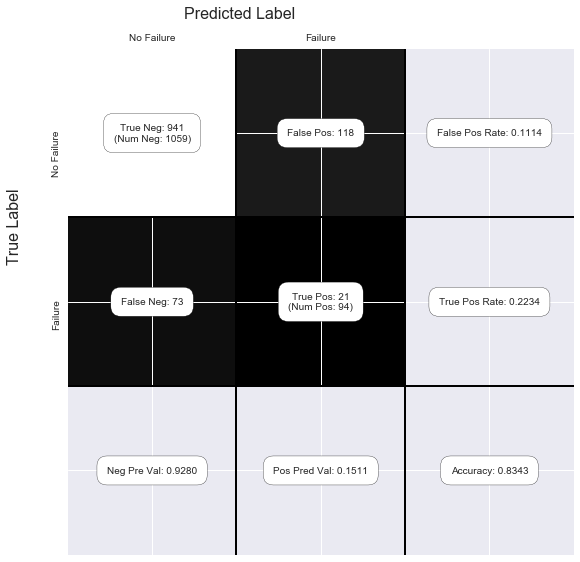

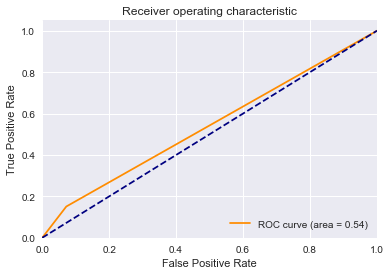

training fold 3 of 10


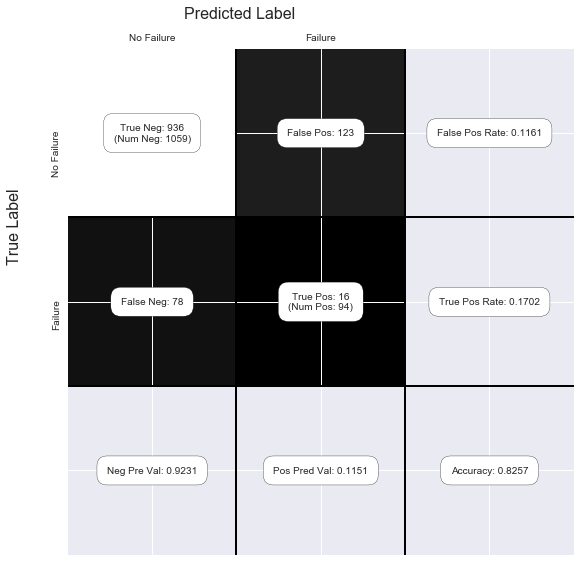

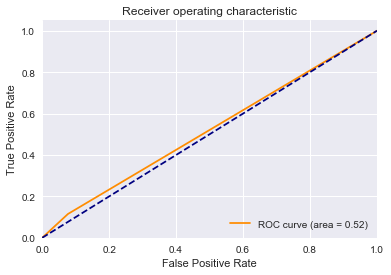

training fold 4 of 10


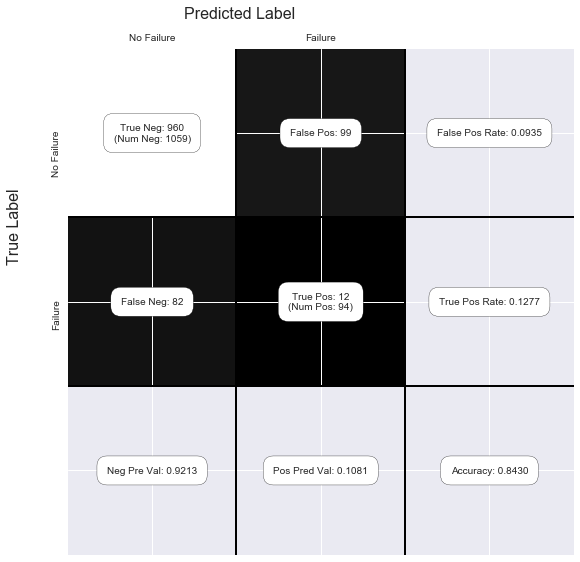

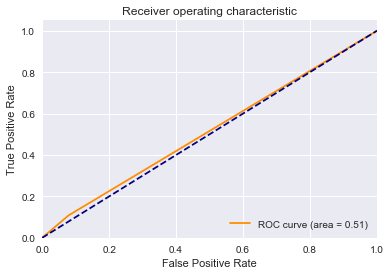

training fold 5 of 10


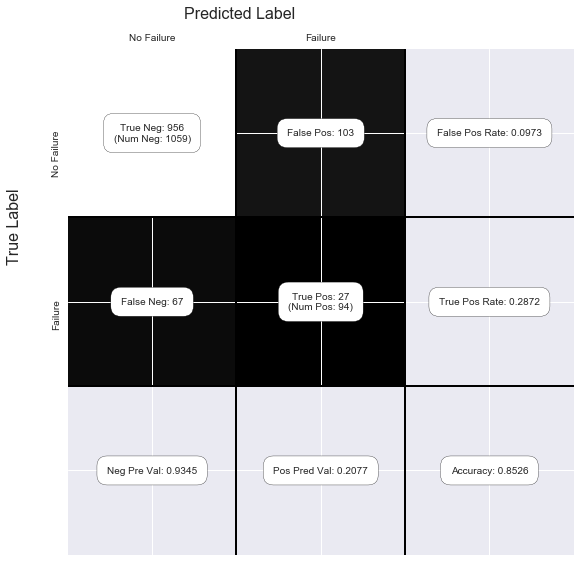

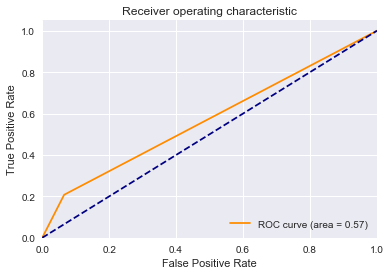

training fold 6 of 10


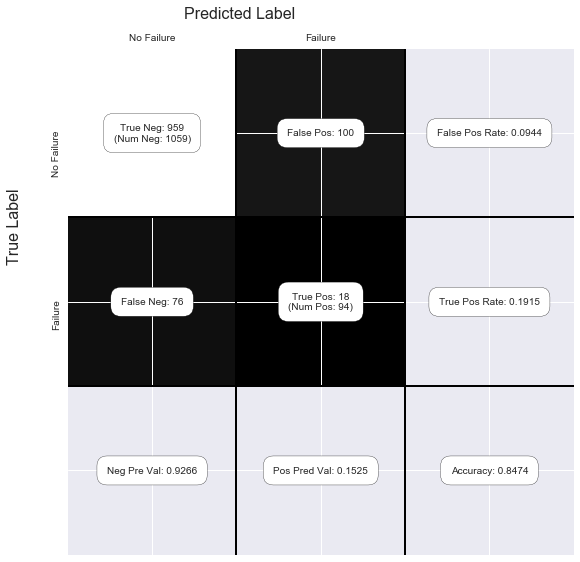

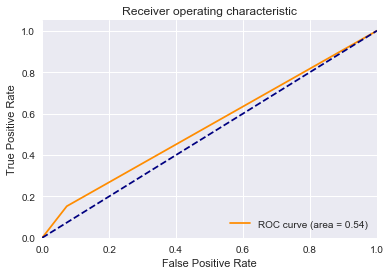

training fold 7 of 10


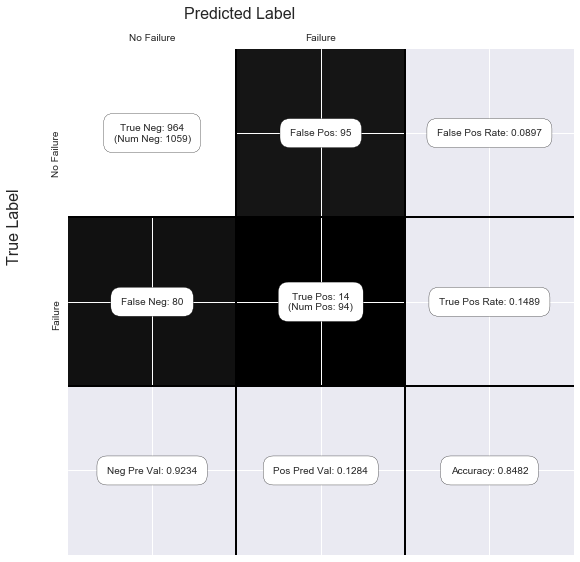

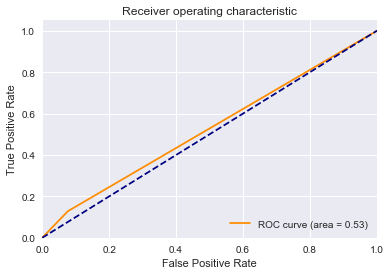

training fold 8 of 10


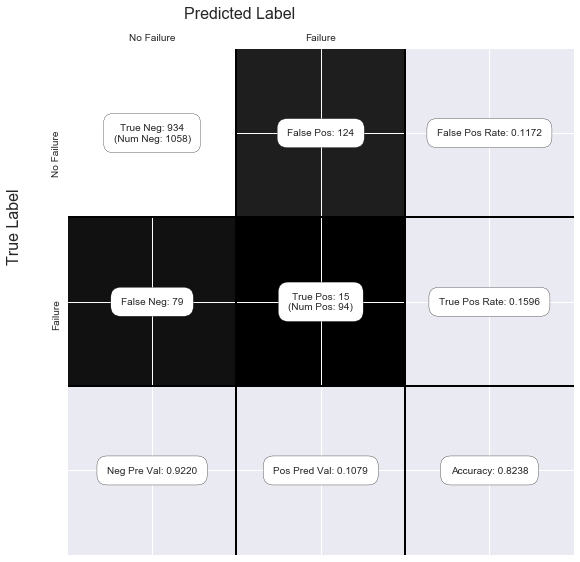

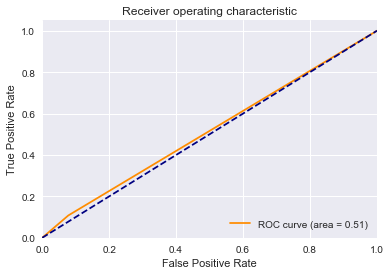

training fold 9 of 10


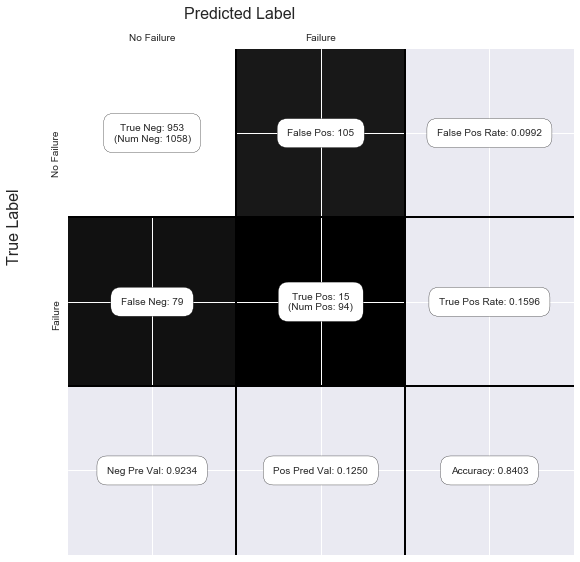

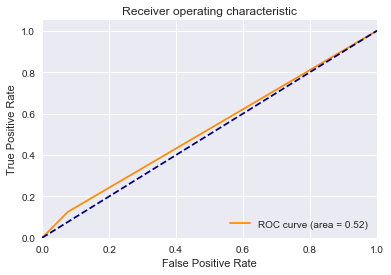

training fold 10 of 10


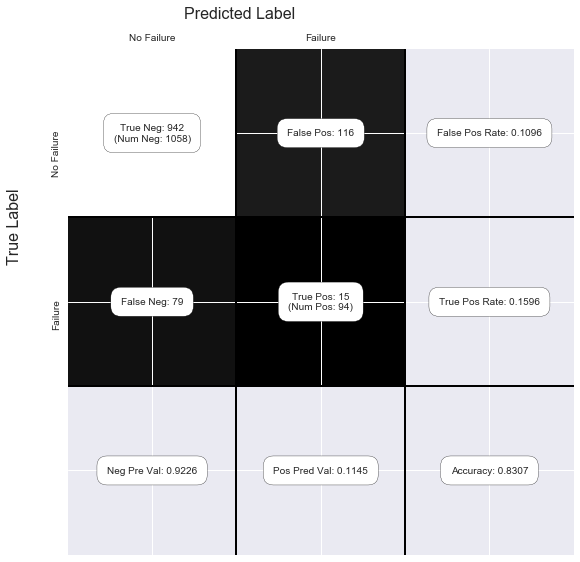

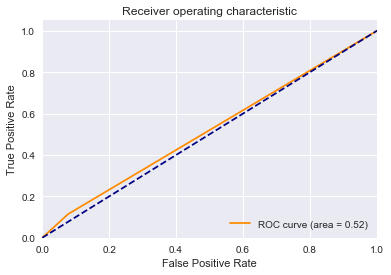

average true positive rate: 0.1829787234042553
Maximum true positive rate: 0.2872340425531915
training full model


In [37]:
'''training_features=['_136222210_count_2_',
           '_136222202_count_1_', '_136222202_count_2_', 
           '_136225010_count_2_', '_136225010_count_1_', '_136224578_count_0_',
           '_136225010_count_0_', '_136222202_count_0_', '_136224586_count_1_',
           '_136224586_count_0_', '_136224578_count_1_', '_136110468_count_2_',
           '_136224578_count_2_', '_136224586_count_2_',
           '_136110468_count_0_']#'_136110468_count_1_'''
training_features=['_136224578_vMean_2_','_136224578_vMean_0_','_136224578_vMean_1_','_136224578_count_1_','_136224578_count_2_','_136224578_count_0_','_136222210_count_0_','_136222210_count_1_','_136222210_count_2_']# '_136224578_count_1_','_136224578_count_2_','_136224578_count_0_',#'_136224578_count_1_',,'_136224578_count_2_''_136224578_count_0_'
target='Label'
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
clf =  LogisticRegression(class_weight={1:10,0:1})
#clf=RandomForestClassifier(max_depth=10, random_state=0,class_weight={1:10,0:1})
#clf =  LogisticRegression()
#clf=SVC(class_weight={1:10,0:1})
#clf = DecisionTreeClassifier(class_weight={1:100,0:1})
DMaxmodel, dtest, dtrain = train_and_calibrate_cv(clf,newtrain[training_features],newtrain[target],10)



In [124]:
verification = getData('data/full1_upload/test_feature/Verification freq 1D, OW 16, PW 1_feature.csv', 'test')
verification

,_Unnamed: 0_level_0_0_,_Unnamed: 0_Unnamed: 1_level_1_,_Unnamed: 1_Unnamed: 2_level_1_,_1_count_,_1.1_vMean_,_1.2_vStd_,_136088194_count_,_136088194.1_vMean_,_136088194.2_vStd_,_136088202_count_,...,_136676682.2_vStd_,_136676698_count_,_136676698.1_vMean_,_136676698.2_vStd_,_136676714_count_,_136676714.1_vMean_,_136676714.2_vStd_,_136676754_count_,_136676754.1_vMean_,_136676754.2_vStd_
0,2,M066_A1,2015-06-04,34.0,21386.330814545454,67253.00917259954,11.0,109683.36149810001,170937.01833636157,0,...,0,0,0,0,0,0,0,0,0,0
1,3,M066_A1,2015-06-05,40.0,21126.197103128205,62760.34000069893,11.0,109683.36149810001,170937.01833636157,0,...,0,0,0,0,0,0,0,0,0,0
2,4,M066_A1,2015-06-06,41.0,21527.279331849997,62021.46871279257,10.0,71987.11791844443,135114.77926223856,0,...,0,0,0,0,0,0,0,0,0,0
3,5,M066_A1,2015-06-07,41.0,21527.279331849997,62021.46871279257,11.0,107390.264433,166465.75703655957,0,...,0,0,0,0,0,0,0,0,0,0
4,6,M066_A1,2015-06-08,43.0,25267.86988538095,65268.31440273438,11.0,107390.264433,166465.75703655957,0,...,0,0,0,0,0,0,0,0,0,0
5,7,M066_A1,2015-06-09,43.0,25267.86988538095,65268.31440273438,11.0,107390.264433,166465.75703655957,0,...,0,0,0,0,0,0,0,0,0,0
6,8,M066_A1,2015-06-10,43.0,25267.86988538095,65268.31440273438,11.0,107390.264433,166465.75703655957,0,...,0,0,0,0,0,0,0,0,0,0
7,9,M066_A1,2015-06-11,44.0,30302.97782639535,72288.87394860772,8.0,115973.771225,183605.00909544344,0,...,0,0,0,0,0,0,0,0,0,0
8,10,M066_A1,2015-06-12,28.0,36548.867460037036,62533.90236066054,8.0,115973.771225,183605.00909544344,0,...,0,0,0,0,0,0,0,0,0,0
9,11,M066_A1,2015-06-13,28.0,36548.867460037036,62533.90236066054,8.0,115973.771225,183605.00909544344,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
def processVer_Data (data):
    newData = pd.DataFrame()
    newData['Machine']=data['_Unnamed: 0_Unnamed: 1_level_1_']
    newData['Date']=data['_Unnamed: 1_Unnamed: 2_level_1_']
    for col in data.columns:
        
        if col not in ['_Unnamed: 0_level_0_0_','_Unnamed: 0_Unnamed: 1_level_1_','_Unnamed: 1_Unnamed: 2_level_1_']:
            newData[col+'0_']=data[col]
            newData[col+'1_']=data[col].copy().shift(1)
            newData[col+'2_']=data[col].copy().shift(2)
            
    # todo: values for different machine should not be in the same line
    newData = newData.fillna(0)  
    
    arr=np.sum(newData.values[:,2:].astype(float), axis=1)
    newData['totalCount'] = arr
    
    
    return newData
#verification = getData('data/full1_upload/test_feature/Verification freq 1D, OW 16, PW 1_feature.csv', 'test')
newtest = processVer_Data(verification)
newtest

,Machine,Date,_1_count_0_,_1_count_1_,_1_count_2_,_1.1_vMean_0_,_1.1_vMean_1_,_1.1_vMean_2_,_1.2_vStd_0_,_1.2_vStd_1_,...,_136676754_count_0_,_136676754_count_1_,_136676754_count_2_,_136676754.1_vMean_0_,_136676754.1_vMean_1_,_136676754.1_vMean_2_,_136676754.2_vStd_0_,_136676754.2_vStd_1_,_136676754.2_vStd_2_,totalCount
0,M066_A1,2015-06-04,34.0,0,0,21386.330814545454,0,0,67253.00917259954,0,...,0,0,0,0,0,0,0,0,0,1.961195e+06
1,M066_A1,2015-06-05,40.0,34.0,0,21126.197103128205,21386.330814545454,0,62760.34000069893,67253.00917259954,...,0,0,0,0,0,0,0,0,0,4.121391e+06
2,M066_A1,2015-06-06,41.0,40.0,34.0,21527.279331849997,21126.197103128205,21386.330814545454,62021.46871279257,62760.34000069893,...,0,0,0,0,0,0,0,0,0,6.048713e+06
3,M066_A1,2015-06-07,41.0,41.0,40.0,21527.279331849997,21527.279331849997,21126.197103128205,62021.46871279257,62021.46871279257,...,0,0,0,0,0,0,0,0,0,5.988045e+06
4,M066_A1,2015-06-08,43.0,41.0,41.0,25267.86988538095,21527.279331849997,21527.279331849997,65268.31440273438,62021.46871279257,...,0,0,0,0,0,0,0,0,0,5.652813e+06
5,M066_A1,2015-06-09,43.0,43.0,41.0,25267.86988538095,25267.86988538095,21527.279331849997,65268.31440273438,65268.31440273438,...,0,0,0,0,0,0,0,0,0,5.528444e+06
6,M066_A1,2015-06-10,43.0,43.0,43.0,25267.86988538095,25267.86988538095,25267.86988538095,65268.31440273438,65268.31440273438,...,0,0,0,0,0,0,0,0,0,5.345414e+06
7,M066_A1,2015-06-11,44.0,43.0,43.0,30302.97782639535,25267.86988538095,25267.86988538095,72288.87394860772,65268.31440273438,...,0,0,0,0,0,0,0,0,0,5.249103e+06
8,M066_A1,2015-06-12,28.0,44.0,43.0,36548.867460037036,30302.97782639535,25267.86988538095,62533.90236066054,72288.87394860772,...,0,0,0,0,0,0,0,0,0,5.013042e+06
9,M066_A1,2015-06-13,28.0,28.0,44.0,36548.867460037036,36548.867460037036,30302.97782639535,62533.90236066054,62533.90236066054,...,0,0,0,0,0,0,0,0,0,4.817096e+06


In [114]:
DMaxmodel.predict(newtest[training_features])

array([1, 1, 0, ..., 0, 0, 0])

In [35]:
features=['_136224578.1_vMean_2_','_136224578.1_vMean_0_','_136224578.1_vMean_1_','_136224578_count_1_','_136224578_count_2_','_136224578_count_0_','_136222210_count_0_','_136222210_count_1_','_136222210_count_2_']

In [38]:
writecsv(DMaxmodel.predict(newtest[features]), verification, 'contest32logistic.csv')